In [172]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, square
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize
from skimage.measure import moments_central, moments_hu
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier

(-0.5, 699.5, 604.5, -0.5)

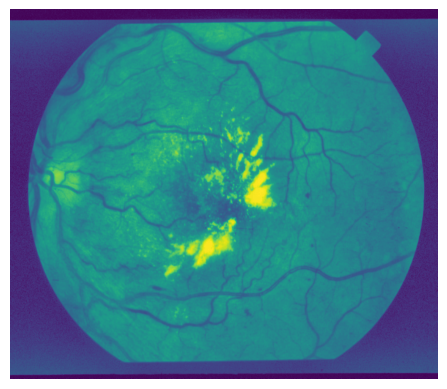

In [173]:
# 1. Wczytaj kolorowy obraz (BGR)
img = cv2.imread("images/im0001.ppm")

img_blur = cv2.GaussianBlur(img, (5, 5), 0)

gray_mask = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)

# Tworzenie maski
_, fov_mask = cv2.threshold(gray_mask, 45, 255, cv2.THRESH_BINARY)
fov_mask = fov_mask > 0  # zamień na maskę logiczną

# Rozmycie Gaussowskie (np. 5x5)




# 1 sposób -----------------------------------------------------------------------------------------------------
# 2. Rozdziel kanały img_blur
b, g, r = cv2.split(img)

# 3. Equalizacja histogramu na każdym kanale osobno
b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

# 4. Połącz ponownie do obrazu BGR
img_eq = cv2.merge((b_eq, g_eq, r_eq))


# ---------------------------------------------------------------------------------------------------------------

# 2 sposób ------------------------------------------------------------------------------------------------------
# Equalizacja tylko jasności Y (w przestrzeni YCrCb) – kolory zostają naturalne
# img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # equalizacja jasności Y
# img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
# ---------------------------------------------------------------------------------------------------------------

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

b_clahe = clahe.apply(b)
g_clahe = clahe.apply(g)
r_clahe = clahe.apply(r)
img_eq = cv2.merge((b_clahe, g_clahe, r_clahe))

# sharpen_kernel = np.array([[0, -1, 0],
#                            [-1, 5, -1],
#                            [0, -1, 0]])

# img_eq = cv2.filter2D(img_eq, -1, sharpen_kernel)

# 5. Konwersja BGR → RGB (skimage używa RGB)
img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)

# 6. Konwersja RGB → Grayscale (float, 0–1)

gray = rgb2gray(img_rgb)
light_mask = gray < 0.9  # zostaw tylko ciemniejsze piksele
plt.plot()
plt.imshow(gray)
plt.axis('off')

/tmp/ipykernel_8385/2929270812.py:10: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_closed = closing(binary, square(3))


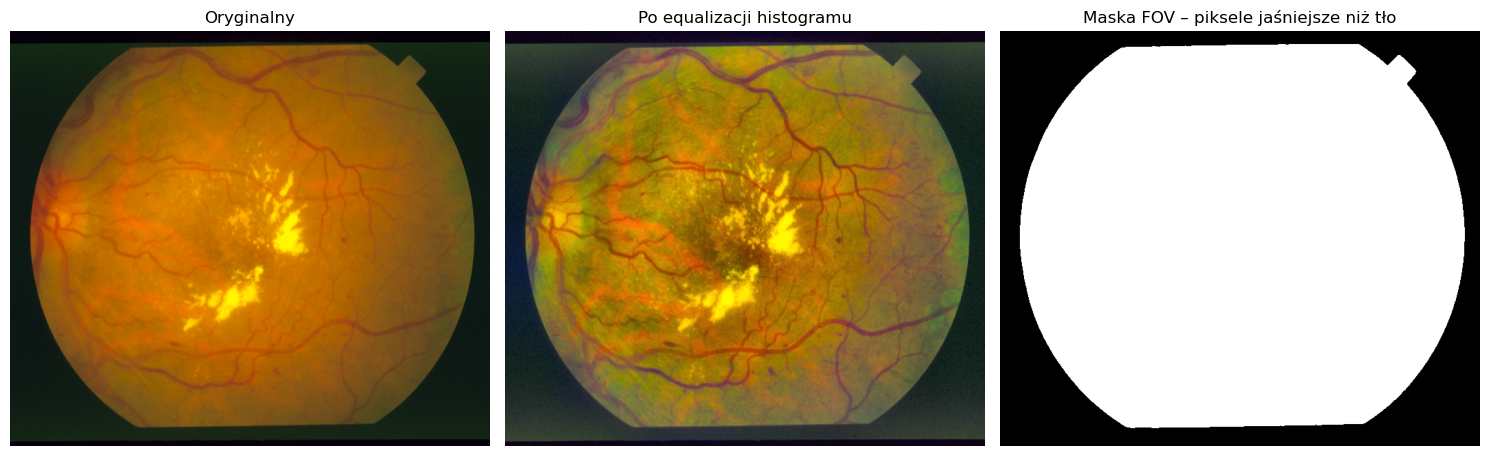

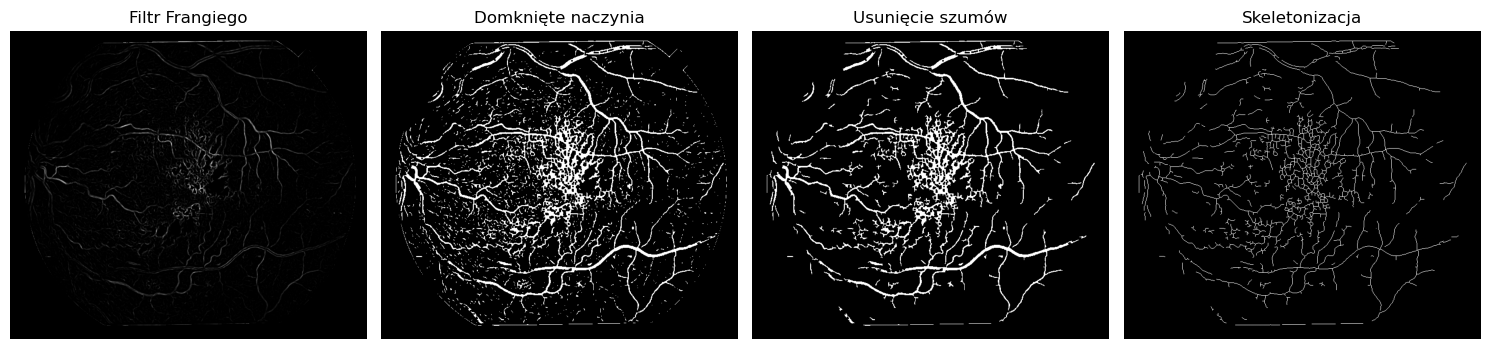

Accuracy: 0.9262
Sensitivity: 0.5224
Specificity: 0.9612
Balanced Accuracy: 0.7418


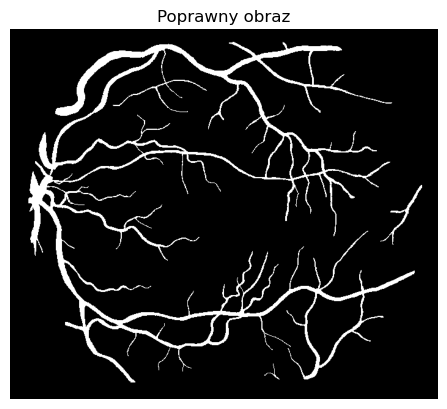

In [174]:




# 7. Zastosowanie filtra Frangiego
frangi_result = frangi(gray)

frangi_result[~fov_mask] = 0

# 8. Progowanie (zamiana obrazu na true -> białe, false -> czarne pixele)
binary = frangi_result > 0.03 

#9. Domyka naczynia
binary_closed = closing(binary, square(3))

#10. Usunięcie szumów
binary_cleaned = remove_small_objects(binary_closed, min_size=20)

#11. Zamienia naczyniana cienkie linie 1px grubości
binary_skeleton = skeletonize(binary_cleaned)

# Wyświetlenie wyników
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Oryginalny")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Po equalizacji histogramu")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Maska FOV – piksele jaśniejsze niż tło")
plt.imshow(fov_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Filtr Frangiego")
plt.imshow(frangi_result, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Domknięte naczynia")
plt.imshow(binary_closed, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Usunięcie szumów")
plt.imshow(binary_cleaned, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Skeletonizacja")
plt.imshow(binary_skeleton, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# Wczytywanie gotowych poprawnych obrazów dna siatkówki oka + progowanie
ideal_result = cv2.imread("images/im0001.ah.ppm", 0) > 0
# ideal_result = cv2.imread("results/im0001-vessels4.ppm", 0) > 0


plt.subplot(1, 1, 1)
plt.title("Poprawny obraz")
plt.imshow(ideal_result, cmap='gray')
plt.axis('off')


TP = np.logical_and(binary_cleaned == 1, ideal_result == 1).sum()
TN = np.logical_and(binary_cleaned == 0, ideal_result == 0).sum()
FP = np.logical_and(binary_cleaned == 1, ideal_result == 0).sum()
FN = np.logical_and(binary_cleaned == 0, ideal_result == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
balanced_accuracy = (sensitivity + specificity) / 2

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")




In [182]:
window_size = 5
step = 2

features = []
labels = []


mask_expert = cv2.imread("images/im0001.ah.ppm", cv2.IMREAD_GRAYSCALE)

rows = []
positions = []


h, w = gray.shape



for y in range(0, h - window_size + 1, step):
    for x in range(0, w - window_size + 1, step):
        # if not light_mask[center_y, center_x]:
        #     continue  # pomiń prześwietlone centrum

        positions.append((y, x))
        patch = gray[y:y+window_size, x:x+window_size]
        
        var = np.var(patch)

        m_central = moments_central(patch)
        hu = moments_hu(m_central)  # 7 cech
        
        center_y = y + window_size // 2
        center_x = x + window_size // 2
        label = mask_expert[center_y, center_x]
        
        row = {
        "var": var,
        "hu_0": hu[0],
        "hu_1": hu[1],
        "hu_2": hu[2],
        "hu_3": hu[3],
        "hu_4": hu[4],
        "hu_5": hu[5],
        "hu_6": hu[6],
        "label": label
        }
        rows.append(row)

        features.append(np.concatenate([[var], hu]))
        labels.append(label)
data = pd.DataFrame(rows)
print(data)

             var      hu_0      hu_1      hu_2      hu_3      hu_4      hu_5  \
0       0.000049  3.316162  0.004745  0.866554  0.005927 -0.000339 -0.000218   
1       0.000030  3.032049  0.000811  0.214523  0.098946  0.008213  0.001023   
2       0.000022  3.134319  0.048440  0.124796  0.001766 -0.000002  0.000302   
3       0.000029  3.011906  0.004705  0.055540  0.037781 -0.000917 -0.001398   
4       0.000058  3.162112  0.031368  0.159806  0.155383 -0.018958  0.025747   
...          ...       ...       ...       ...       ...       ...       ...   
104743  0.000036  3.057248  0.026852  0.409576  0.024351 -0.002369  0.003697   
104744  0.000039  2.923292  0.022769  0.023422  0.027699 -0.000141 -0.002478   
104745  0.000044  2.837919  0.010075  0.168104  0.028680 -0.001939 -0.002168   
104746  0.000035  2.966191  0.004304  0.072686  0.032840  0.000625  0.001015   
104747  0.000055  2.844444  0.267822  0.051810  0.030902 -0.000372  0.014929   

            hu_6  label  
0       0.000

In [183]:
# Divide the data into feature matrix X and target vector y
X = data.iloc[:,:-1]
print(X)
Y = data.iloc[:,-1]
print(y)

             var      hu_0      hu_1      hu_2      hu_3      hu_4      hu_5  \
0       0.000049  3.316162  0.004745  0.866554  0.005927 -0.000339 -0.000218   
1       0.000030  3.032049  0.000811  0.214523  0.098946  0.008213  0.001023   
2       0.000022  3.134319  0.048440  0.124796  0.001766 -0.000002  0.000302   
3       0.000029  3.011906  0.004705  0.055540  0.037781 -0.000917 -0.001398   
4       0.000058  3.162112  0.031368  0.159806  0.155383 -0.018958  0.025747   
...          ...       ...       ...       ...       ...       ...       ...   
104743  0.000036  3.057248  0.026852  0.409576  0.024351 -0.002369  0.003697   
104744  0.000039  2.923292  0.022769  0.023422  0.027699 -0.000141 -0.002478   
104745  0.000044  2.837919  0.010075  0.168104  0.028680 -0.001939 -0.002168   
104746  0.000035  2.966191  0.004304  0.072686  0.032840  0.000625  0.001015   
104747  0.000055  2.844444  0.267822  0.051810  0.030902 -0.000372  0.014929   

            hu_6  
0       0.000256  
1

In [184]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
print(scaled_data)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(scaled_data, Y)


[[-4.18224295e-01 -2.19813690e+00 -3.90939059e-01 ... -6.30987282e-02
   5.95955905e-02  1.33943353e-04]
 [-4.29320626e-01 -2.21629793e+00 -3.93406189e-01 ... -6.30887171e-02
   5.96563514e-02  1.10945751e-04]
 [-4.33686172e-01 -2.20976065e+00 -3.63536047e-01 ... -6.30983338e-02
   5.96210763e-02  1.33507124e-04]
 ...
 [-4.21250569e-01 -2.22870714e+00 -3.87596262e-01 ... -6.31006005e-02
   5.95001304e-02  1.34322908e-04]
 [-4.26256734e-01 -2.22050772e+00 -3.91215804e-01 ... -6.30975993e-02
   5.96559945e-02  1.30649800e-04]
 [-4.14877807e-01 -2.22829007e+00 -2.25949756e-01 ... -6.30987666e-02
   6.03372465e-02  1.35698118e-04]]


In [185]:
# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.2, random_state=32)

SVM model accuracy: 0.84
SVM model confusion matrix:
[[1392  289]
 [ 156 1535]]
SVM model classification report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1681
         255       0.84      0.91      0.87      1691

    accuracy                           0.87      3372
   macro avg       0.87      0.87      0.87      3372
weighted avg       0.87      0.87      0.87      3372



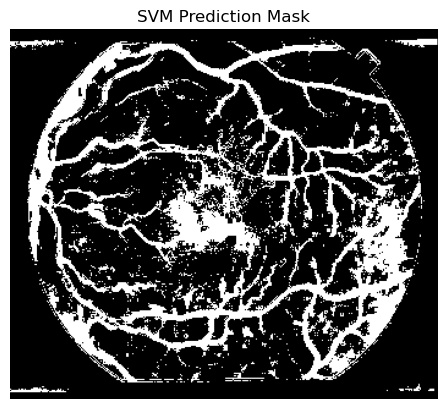

In [186]:
# Create SVM model
svm_model = svm.SVC(kernel='rbf', C=1, class_weight='balanced')
# Train the model
svm_model.fit(X_train, y_train)
# Make predictions
y_pred_svm = svm_model.predict(X_test)
y_final = svm_model.predict(scaled_data)
# Evaluate the model
accuracy_svm = accuracy_score(Y, y_final)
print(f"SVM model accuracy: {accuracy_svm:.2f}")
# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(f"SVM model confusion matrix:\n{cm_svm}")
# Classification report
cr_svm = classification_report(y_test, y_pred_svm)
print(f"SVM model classification report:\n{cr_svm}")


height, width = gray.shape
grid_h = (height - window_size) // step + 1
grid_w = (width - window_size) // step + 1
prediction_image = np.array(y_final).reshape((grid_h, grid_w))
full_mask = cv2.resize(prediction_image.astype(np.uint8), (width, height), interpolation=cv2.INTER_LINEAR)


output_mask = np.zeros_like(gray, dtype=np.uint8)


output_mask = np.zeros_like(gray, dtype=np.uint8)

for idx, (y, x) in enumerate(positions):
    class_label = y_final[idx]
    output_mask[y:y+window_size, x:x+window_size] = class_label

plt.imshow(output_mask, cmap='gray')
plt.title("SVM Prediction Mask")
plt.axis('off')
plt.show()

k-NN model accuracy: 0.90
k-NN model confusion matrix:
[[1503  178]
 [ 455 1236]]
k-NN model classification report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1681
         255       0.87      0.73      0.80      1691

    accuracy                           0.81      3372
   macro avg       0.82      0.81      0.81      3372
weighted avg       0.82      0.81      0.81      3372



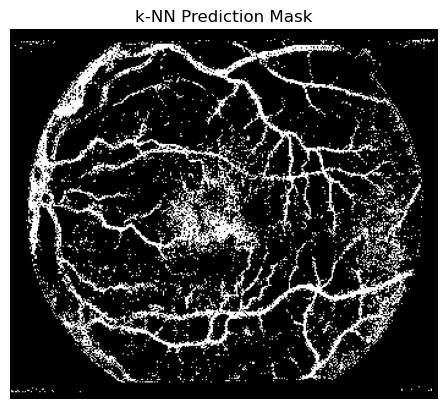

In [187]:
# Create and train k-NN model
knn_model = KNeighborsClassifier(n_neighbors=2)  # możesz zmienić k np. na 3 lub 7
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)
y_final_knn = knn_model.predict(scaled_data)

# Evaluate k-NN model
accuracy_knn = accuracy_score(Y, y_final_knn)
print(f"k-NN model accuracy: {accuracy_knn:.2f}")

cm_knn = confusion_matrix(y_test, y_pred_knn)
print(f"k-NN model confusion matrix:\n{cm_knn}")

cr_knn = classification_report(y_test, y_pred_knn)
print(f"k-NN model classification report:\n{cr_knn}")

# Generate mask for k-NN
prediction_image_knn = np.array(y_final_knn).reshape((grid_h, grid_w))
full_mask_knn = cv2.resize(prediction_image_knn.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST)

# Tworzenie maski wynikowej dla k-NN
output_mask_knn = np.zeros_like(gray, dtype=np.uint8)

for idx, (y, x) in enumerate(positions):
    class_label = y_final_knn[idx]
    output_mask_knn[y:y+window_size, x:x+window_size] = class_label

# Wizualizacja
plt.imshow(output_mask_knn, cmap='gray')
plt.title("k-NN Prediction Mask")
plt.axis('off')
plt.show()